# Some attempts at spike inference
A notebook with a few unorganized attempts at spike inference. The more effective functions will probably get organized and rehomed in the `retinapy` package.

In [1]:
import pathlib
import torch
import numpy as np
import retinapy
import retinapy.mea as mea
import retinapy.spikeprediction as sp
import retinapy.spikedistancefield as sdf
import plotly
import plotly.express
import plotly.graph_objects as go
import plotly.subplots as subplots
from typing import Optional
import math
import einops
import scipy
import collections
import sklearn
import sklearn.metrics
import torch.nn.functional as F

In [2]:
eval_step_ms = 100
sample_rate = 1983.641
eval_step_bins = round((eval_step_ms/1000)*sample_rate)
print(eval_step_bins)

198


In [3]:
def get_sample(ds, idx):
    """Don't forget how to get the samples as tensor tuples."""
    sample = torch.utils.data.dataloader.default_collate([ds[idx]])
    return sample

In [4]:
data_dir = pathlib.Path("../data/ff_noise_recordings")
project_root = pathlib.Path("../")
out_dir = project_root / "out/exp/1/3/1/tf_9ds3174in_bs512ds7z60t8nH12Hd32b1e3/0"
model_ckpt = out_dir / "Transformer-9ds_3174in/recovery.pth"
#out_dir = project_root / "out/exp/1/3/1/tf_18ds_1586in_lr1e3bs1024ds6z50t5nH14Hd32b1e2/0"
#model_ckpt = out_dir / "Transformer-18ds_1586in/recovery.pth"
out_dir = project_root / "out/demo/transformer_21_9ds/1"
model_ckpt = out_dir / "Transformer-9ds_3174in/checkpoint_best_loss.pth"
arg_file = out_dir / "args.yaml"
opt = sp.args_from_yaml(arg_file)
opt.stride = eval_step_bins
assert pathlib.Path(model_ckpt).resolve().exists()
assert pathlib.Path(model_ckpt).exists()

In [5]:
def load_all_recs():
    # Load the data.
    recordings = mea.load_3brain_recordings(
        data_dir,
        #include=['Chicken_04_08_21_Phase_01',
        #    'Chicken_04_08_21_Phase_02']
    )
    ## Filter the recording with different sample rate
    skip_rec_names = {"Chicken_21_08_21_Phase_00"}
    recordings = [r for r in recordings if r.name not in skip_rec_names]
    return recordings

def load_rec():
    rec = mea.single_3brain_recording(
        "Chicken_17_08_21_Phase_00",
        data_dir,
        #include_clusters={21, 138}
        include_clusters={21}
    )
    return [rec]

#recs = load_all_recs()
recs = load_rec()

In [6]:
#config = sp.Configuration(downsample=18, input_len=1586, output_len=100)
#trainable = sp.TransformerTGroup.create_trainable(recs, config, opt=opt, num_recs=16, max_num_clusters=623)
config = sp.Configuration(downsample=9, input_len=3174, output_len=400)
trainable = sp.TransformerTGroup.create_trainable(recs, config, opt=opt)#, num_recs=16, max_num_clusters=623)

In [7]:
ckpt = torch.load
retinapy.models.load_model(trainable.model, model_ckpt)
trainable.model.cuda()
trainable.model.eval();

In [8]:
def distance_loss(spikes, default_distance: float):
    spike_indicies = (spikes == 1).nonzero()[0]
    all_indicies = torch.arange(len(spikes), device=spikes.device, requires_grad=True, dtype=torch.float32)
    for s in spike_indicies:
        dist_field = torch.min(dist_field, torch.abs(all_indicies - s))
    return dist_field

def gradient_infer(df):
    max_spikes = 10
    num_bins = len(df)
    default_distance = 600.0
    spikes = torch.arange(0, len(df), requires_grad=True, dtype=torch.float32, device=df.device)
    optimizer = torch.optim.SGD([spikes], lr=1e-3)
    def loss_fn(spikes_, target_df):
        rgrid = torch.arange(len(target_df), dtype=torch.float32, device=spikes_.device, 
                             requires_grad=True).unsqueeze(0).expand((len(spikes_), -1))
        distf, _ = torch.min(torch.abs(rgrid - spikes_.unsqueeze(-1)), dim=0)
        loss = torch.mean((distf - target_df)**2)
        return loss, distf
    max_steps = 9000
    for s in range(max_steps):
        optimizer.zero_grad()
        loss, distf = loss_fn(spikes, df)
        loss.backward()
        optimizer.step()
    spikes = torch.round(spikes)
    print(spikes)
    print(distf)
    num_spikes = len(torch.unique(spikes[spikes > 0]))
    zero_case = torch.mean((df - default_distance)**2)
    print(zero_case, loss)
    if loss < zero_case:
        res = num_spikes
    else:
        res = 0
    return res

In [9]:
def infer_spikes_via_area(dist, eval_len, threshold, offset=0):
    start = offset
    end = offset + eval_len
    kernel = torch.FloatTensor(
        [[[0.25, 0.5, 0.25]]]
    ).to(dist.device)
    smoothed = torch.squeeze(F.conv1d(dist[None,...], kernel, padding=0))
    smoothed = smoothed[start:end]
    above_threshold = (smoothed > threshold)
    #transitions = (torch.diff(above_threshold.float(), 1, dim=0) < 0)
    #transitions += (torch.diff((smoothed > 0).float(), 1, dim=0) < 0)
    down = torch.sum((torch.diff((smoothed > 0.3).float(), 1, dim=0) < 0)).item()
    up = torch.sum((torch.diff((smoothed < 0.3).float(), 1, dim=0) < 0)).item()
    _min = min(up, down)
    integral = torch.sum(~above_threshold).float() / (math.log(eval_len)*8)
    _max = eval_len / (3*2) # 6 per 10ms
    res = max(_min, min(_max, integral))
    return res


In [10]:
def infer_spikes_via_spline(dist, dist_threshold, grad_threshold, smoothing=0):
    #spline = scipy.interpolate.InterpolatedUnivariateSpline(x=xs,  y=dist, k=4)#s=smoothing)
    downsample = 1
    dist_ds = scipy.signal.decimate(dist, downsample)
    xs = np.arange(len(dist_ds))
    spline = scipy.interpolate.UnivariateSpline(x=xs,  y=dist_ds, k=4, s=smoothing)
    roots_idxs = np.round(spline.derivative().roots()).astype(int)
    grad2_at_roots = spline.derivative().derivative()(roots_idxs)
    dist_at_roots = spline(roots_idxs)
    minima_idxs = roots_idxs[np.logical_and(grad2_at_roots > 0, 
                                            dist_at_roots < dist_threshold)] * downsample
    minima = np.zeros_like(dist)
    minima[minima_idxs] = 1
    return minima, spline
    grad = spline.derivative(n=1)(xs)
    grad2 = spline.derivative(n=2)(xs)
    is_near_spike = (spline(xs) < dist_threshold)
    is_near_local_extremum = (grad < grad_threshold)
    is_min = (grad2 > 0)
    spikes = is_near_spike & is_near_local_extremum & is_min
    return spikes, spline


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.

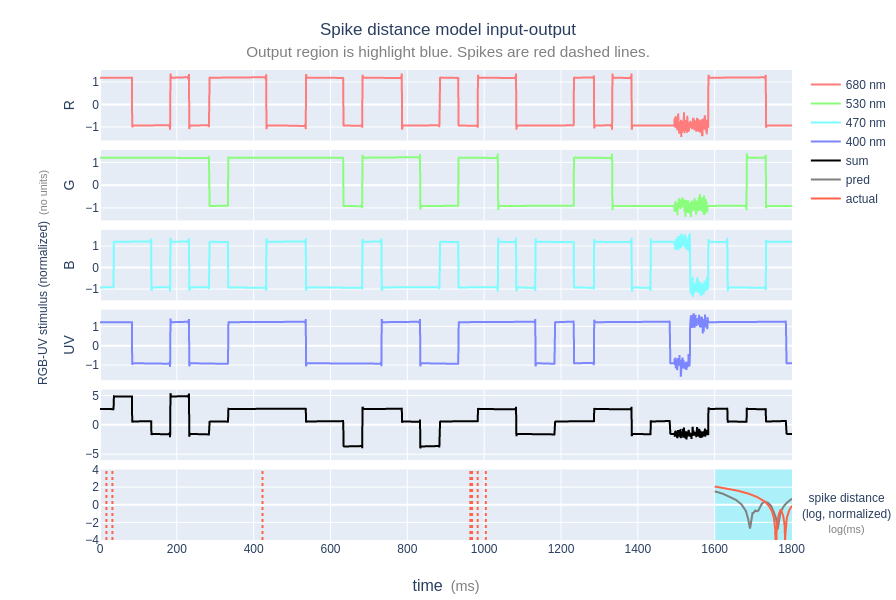

In [11]:
def predict_sample(idx):
    with torch.no_grad():
        s = get_sample(trainable.val_ds, idx)
        predict, _ = trainable.forward(s)
    #predict_count = gradient_infer(trainable.nn_output_to_distfield(predict)[0])
        predict_count, _ = infer_spikes_via_spline(
            trainable.nn_output_to_distfield(predict)[0].cpu().numpy(), dist_threshold=10.2, grad_threshold=0.1)
        print(predict_count, np.count_nonzero(predict_count))
    fig = retinapy.vis.distfield_model_in_out(
        s['snippet'][0][0:-1].numpy(),
        s['snippet'][0][-1].numpy(),
        trainable.distfield_to_nn_output(s['dist'][0]),
        predict[0].cpu().numpy(),
        bin_duration_ms=trainable.sample_period_ms)
    fig.show()
predict_sample(650)

In [12]:
def self_eval(trainable, test_ds):
    trainable.eval_lengths_ms = [1,5,10,20,50,100]
    trainable.max_eval_count = 1e6
    test_dl = torch.utils.data.DataLoader(
        test_ds,
        batch_size=512,
        shuffle=True,
        drop_last=False,
        num_workers=20)
    with torch.no_grad():
        results = trainable.evaluate(test_dl)
    return results

In [13]:
#results = self_eval(trainable, trainable.test_ds)

In [14]:
def display_stats(metrics):
    for m in metrics:
        print(f'{m.name}: {m.value:.2f}')
#display_stats(results['metrics'])

## Batch attempt
Doesn't work. Produces output like: 
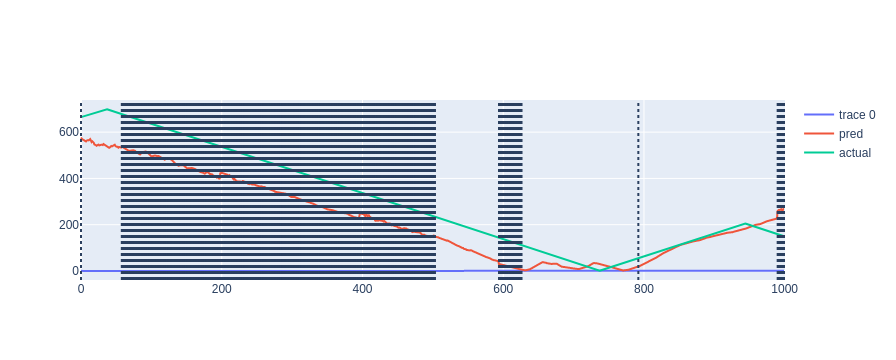

In [15]:
def _init_dist_like(target_dist, max_dist, lhs_spike):
    dist = torch.min(
        einops.rearrange(
            torch.arange(-lhs_spike, (-lhs_spike) + target_dist.shape[1], device=target_dist.device), 
            't -> () t'),
        torch.full_like(target_dist, max_dist))
    return dist
    
def _update_dist(dist, max_dist, spike_idx):
    if max_dist < len(dist):
        raise ValueError("It's assumed that the maximum distance "
                         "value is larger than the dist array length.") 
    if spike_idx < 0:    
        raise ValueError("Use init_dist to create and initialize the distance array.") 
    max_dist = min(max_dist, dist.shape[1])
    spike_and_after = einops.repeat(
        torch.arange(max_dist, device=dist.device), 't -> b t', b=dist.shape[0])
    dist_left_of_spike = torch.flip(spike_and_after, dims=(1,))[:,:-1]
    dist_around_spike = torch.cat([dist_left_of_spike, spike_and_after], dim=1)
    mid = len(dist_around_spike) // 2
    l_idx = max(0, mid - spike_idx)
    r_idx = l_idx + dist.shape[1]
    updated_dist = torch.min(dist, dist_around_spike[:, l_idx:r_idx])
    return updated_dist


def predict(target_dist, max_dist, lhs_spike, max_eval_len):        
    batch_size = target_dist.shape[0]
    device = target_dist.device
    if lhs_spike is None:
        lhs_spike = -max_dist
    dist = _init_dist_like(target_dist, max_dist, lhs_spike)
    target_minus_curr = target_dist - dist
    
    def loss(diff1, diff2):
        l1_loss1 = torch.mean(torch.abs(diff1), dim=1)
        l1_loss2 = torch.mean(torch.abs(diff2), dim=1)
        return l1_loss1, l1_loss2
        
    res_spikes = torch.zeros(size=[batch_size, max_eval_len], device=device)
    for i in range(max_eval_len):
        proposed_dist = _update_dist(dist, max_dist, spike_idx=i)
        target_minus_proposed = target_dist - proposed_dist
        lp, lc = loss(target_minus_proposed, target_minus_curr)
        has_new_spikes = (lp < lc)
        res_spikes[:,i] = has_new_spikes.int()
        #curr_update_mask = einops.repeat(has_new_spikes, 'b -> b t', t=res_spikes.shape[1])
        curr_update_mask = einops.rearrange(has_new_spikes, 'b -> b ()')
        target_minus_curr.masked_scatter_(curr_update_mask, target_minus_proposed)
        target_minus_curr = target_minus_proposed
    return res_spikes

def eval_model_batched(trainable, test_ds):
    print(f"stride: {test_ds.stride}")
    eval_lengths_ms = [1,5,10,20,50,100]
    max_eval_bins = trainable.ms_to_bins(max(eval_lengths_ms))
    trainable.max_eval_count = 1e6
    test_dl = torch.utils.data.DataLoader(
        test_ds,
        batch_size=512,
        shuffle=False,
        drop_last=False,
        num_workers=20)
    # (rec_id, cluster_id) -> list[np.array]
    pred_spikes = collections.defaultdict(list) 
    actual_spikes = collections.defaultdict(list)
    pred_dist_res = collections.defaultdict(list)
    actual_dist_res = collections.defaultdict(list)
    with torch.no_grad():
        for i, sample in enumerate(test_dl):
            if i > 100:
                break
            model_out, _ = trainable.forward(sample)
            dist = trainable.nn_output_to_distfield(model_out)
            input_spikes = sample['snippet'][:,-1]
            lhs_spike =  torch.clamp(
                torch.argmin((input_spikes > 0).int()) - input_spikes.shape[1],
                -trainable.max_bin_dist)
            p_spikes = predict(dist, trainable.max_bin_dist, lhs_spike, max_eval_bins)
            rec_id, cluster_id = sample['rec_id'], sample['cluster_id']
            target_spikes = sample['target_spikes'][:,0:max_eval_bins].cpu().numpy()
            pdist = dist[:,0:max_eval_bins].cpu().numpy()
            adist = sample['dist'][:,0:max_eval_bins].cpu().numpy()
            assert target_spikes.shape == p_spikes.shape, f"{target_spikes.shape}, {p_spikes.shape}"
            for r,c,psp,tsp,pd,ad in zip(rec_id, cluster_id, 
                                     list(p_spikes.cpu().numpy()), 
                                     list(target_spikes),
                                     list(pdist),
                                     list(adist)):
                pred_spikes[(r.item(), c.item())].append(psp)
                actual_spikes[(r.item(), c.item())].append(tsp)
                pred_dist_res[(r.item(), c.item())].append(pd)
                actual_dist_res[(r.item(), c.item())].append(ad)
                                     
    # another dictionary, but value is single numpy array.
    concat_pred = dict(map(lambda item: (item[0], np.concatenate(item[1])), pred_spikes.items()))
    concat_actual = dict(map(lambda item: (item[0], np.concatenate(item[1])), actual_spikes.items()))
    concat_pdist = dict(map(lambda item: (item[0], np.concatenate(item[1])), pred_dist_res.items()))
    concat_adist = dict(map(lambda item: (item[0], np.concatenate(item[1])), actual_dist_res.items()))
    return concat_pred, concat_actual, concat_pdist, concat_adist

stride: 198


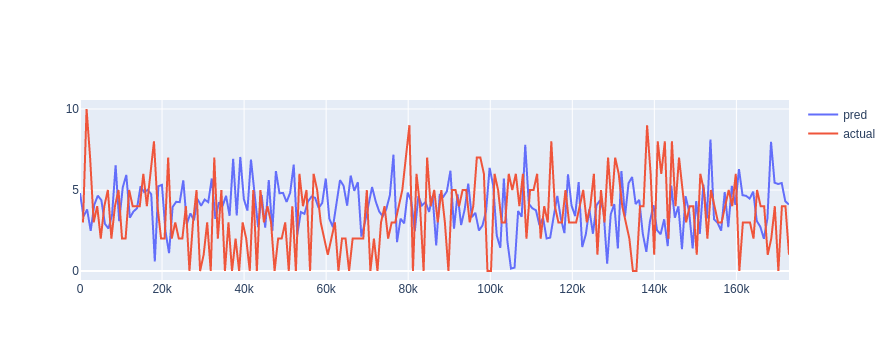

In [16]:
pred, actual, pdist, adist = eval_model_batched(trainable, trainable.test_ds)
pred_histogram = np.histogram(np.flatnonzero(pred[(0,0)]), bins=200)
actual_histogram = np.histogram(np.flatnonzero(actual[(0,0)]), bins=200)
fig = plotly.graph_objects.Figure()
fig.add_trace(
    plotly.graph_objects.Scatter(
        x=pred_histogram[1],
        y=pred_histogram[0]/100,
        name='pred')
)
fig.add_trace(
    plotly.graph_objects.Scatter(
        x=actual_histogram[1],
        y=actual_histogram[0],
        name='actual')
)
fig.show()

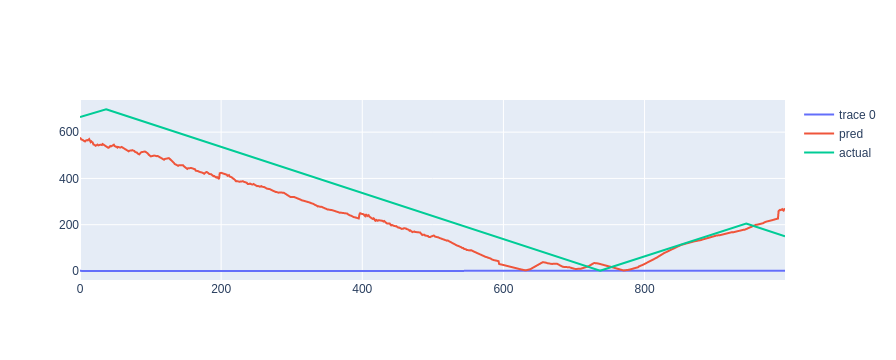

In [17]:
fig = plotly.graph_objects.Figure()
plot_len = 1000
spike_idxs = np.flatnonzero(pred[(0,0)][0:plot_len] > 0)
# Issue with this method predicting too many spikes
if len(spike_idxs) < 20:
    for indx in spike_idxs:
        fig.add_vline(
            x= indx, line_dash="dot")
fig.add_trace(
    plotly.graph_objects.Scatter(
        x=np.arange(plot_len),
        y=pred[(0,0)][0:plot_len]
    )
)
fig.add_trace(
    plotly.graph_objects.Scatter(
        x=np.arange(plot_len),
        y=pdist[(0,0)][0:plot_len],
        name="pred"
    )
)
fig.add_trace(
    plotly.graph_objects.Scatter(
        x=np.arange(plot_len),
        y=adist[(0,0)][0:plot_len],
        name="actual"
    )
)
fig.show()

## Single 

In [18]:
class SpikeLinkedList:
    
    class Node:
        def __init__(self, pos : int, target_dist : torch.Tensor):
            self.pos = pos
            self.lnode = None
            self.rnode = None
            self.target_dist = target_dist
            self.is_l_shared = None
            self.is_r_shared = None
            self.is_removed = False
            
        def responsibility(self):
            assert not self.is_removed
            if self.lnode is None:
                left_r = 0
            else:
                num_shared = (self.pos - 1) - self.lnode.pos
                #num_responsible = (num_shared + 1) // 2
                num_responsible = num_shared // 2
                left_r = self.pos - num_responsible
            if self.rnode is None:
                right_r = len(self.target_dist)
            else:
                num_shared = (self.rnode.pos - 1) - self.pos
                #num_responsible = (num_shared + 1) // 2
                num_responsible = num_shared // 2
                right_r_inclusive = self.pos + num_responsible
                right_r = self.pos + num_responsible + 1
            assert left_r < right_r
            assert left_r <= self.pos and right_r > self.pos, ('Responsibility '
                'must at least include self.pos (self.pos, left_r, right_r)'
                f' was ({self.pos}, {left_r}, {right_r})')
            return (left_r, right_r)
        
        def dist_arrs(self, l_idx, r_idx):
            """
            r_idx is exclusive (inclusive + 1)
            """
            assert not self.is_removed
            if l_idx > self.pos or r_idx <= self.pos:
                # For the current use case, we always ask for the full responsibility of
                # a node, and so it's correct to assert this bound. However, the method
                # is more general, at it may be desired later to relax this.
                raise ValueError("Left and right bounds should contain self.pos. Got "
                                 f"({l_idx, r_idx}) with self.pos = {self.pos}")
            dist = torch.zeros(size=[r_idx - l_idx], device=self.target_dist.device)
            dist_inverted = torch.zeros(size=[r_idx - l_idx], device=self.target_dist.device)
            rel_pos = self.pos - l_idx
            # LEFT
            if l_idx < self.pos:
                ldist = torch.flip(torch.arange(self.pos - l_idx), dims=(0,)) + 1
                dist[0:rel_pos] = ldist
                min_replacement_dist = self.pos - l_idx
                if not self.is_l_shared:
                    min_replacement_dist += 1
                if self.lnode:
                    dist_inverted[0:rel_pos] = torch.flip(ldist, dims=(0,)) + min_replacement_dist
                else:
                    # Special treatment for the last node
                    assert self.lnode is None
                    dist_inverted[0:rel_pos] = ldist + (r_idx - self.pos)
            # RIGHT
            if r_idx > self.pos:
                rdist = torch.arange(r_idx - self.pos)
                dist[rel_pos:] = rdist
                min_replacement_dist = (r_idx - 1) - self.pos 
                if not self.is_r_shared:
                    min_replacement_dist += 1
                # This depends on whether we are the last spike.
                if self.rnode:
                    dist_inverted[rel_pos:] = torch.flip(rdist, dims=(0,)) + min_replacement_dist
                else:
                    # Special treatment for the last node
                    assert self.rnode is None
                    # I guess that dist_inverted isn't a good name anymore....
                    # Give all responsibility to the node on the left.
                    dist_inverted[rel_pos:] = rdist + rel_pos
                min_dist = 0 #0.25
                dist[rel_pos] = min_dist
            return dist, dist_inverted
                
            
        def set_lnode(self, lnode):
            assert not self.is_removed
            self.lnode = lnode
            num_shared = self.pos - lnode.pos - 1
            # is the left-most point shared?
            self.is_l_shared = num_shared % 2
                    
            
        def set_rnode(self, rnode):
            assert not self.is_removed
            self.rnode = rnode
            num_shared = rnode.pos - self.pos - 1
            # is the right-most point shared?
            self.is_r_shared = num_shared % 2
        
        
    def __init__(self, trainable, target_dist : torch.Tensor, lhs_spike : int):
        if lhs_spike > 0:
            raise ValueError(f"lhs is expected to be negative. ({lhs_spike})")
        self.lhs_spike = lhs_spike
        self.trainable = trainable
        self.max_dist = trainable.max_bin_dist
        self.target_dist = target_dist 
        self.init_dist = torch.clamp(torch.arange(len(target_dist), device=self.target_dist.device)
                                     - self.lhs_spike, max=self.max_dist)
        
        # Create linked list
        self.first_node = self.Node(pos=0, target_dist=self.target_dist)
        self.last_node = self.first_node
        #init_scores = torch.randperm(len(target_dist))
        init_scores = target_dist
        self.scores = [(init_scores[0], self.first_node)]
        self.num_nodes = 1
        for i in range(1, len(target_dist)):
            node = self.Node(pos=i, target_dist=self.target_dist)
            self.last_node.set_rnode(node)
            node.set_lnode(self.last_node)
            self.last_node = node
            self.num_nodes += 1
            self.scores.append((init_scores[i], node))
            
            
    def remove(self, node):
        if node is None:
            raise ValueError("Called remove(None)")
        if node.lnode is None:
            # Removing the first node
            self.first_node = node.rnode
        else:
            node.lnode.rnode = node.rnode
        if node.rnode is None:
            # Removing the last node
            self.last_node = node.lnode
        else:
            node.rnode.lnode = node.lnode
        self.num_nodes -= 1
        node.is_removed = True
        return node.rnode
    
    def should_remove(self, node):
        assert not node.is_removed
        l_idx, r_idx = node.responsibility()
        curr_dist, alternative_dist = node.dist_arrs(l_idx, r_idx)
        if node.lnode is None:
            # We are the first spike, so need special treatment for alternative.
            assert self.lhs_spike < 0 
            alternative_dist = torch.min(alternative_dist, self.init_dist[0:len(alternative_dist)])
            curr_dist[0:node.pos] = torch.min(curr_dist[0:node.pos], self.init_dist[0:node.pos])
        curr_loss = self.loss(curr_dist, self.target_dist[l_idx:r_idx])
        alternative_loss = self.loss(alternative_dist, self.target_dist[l_idx:r_idx])
        threshold = 0.02 # larger, e.g. 0.10 encouranges less spikes
        res = alternative_loss < curr_loss + threshold
        best_loss = min(alternative_loss, curr_loss)
        return res, best_loss
    
    def loss(self, pdist, tdist):
        # This next line encourages more spikes. The idea is that the target distance
        # function is really sharp in log space, and the model is probably not so capable
        # of reaching the minimum, so don't penalize it when trying to find the MLE set of
        # spikes.
        # This is balanced with the "threshold" parameter above.
        pdist_nn = torch.clamp(self.trainable.distfield_to_nn_output(pdist), min=-4.0)
        #pdist_nn = self.trainable.distfield_to_nn_output(pdist)
        l1_loss = torch.norm(pdist_nn - tdist)
        return l1_loss
            
    def reduce(self):
        n = self.first_node
        new_scores = []
        for s,n in sorted(self.scores, key=lambda s:s[0]):
        #for s,n in random.sample(self.scores, len(self.scores)):
        #while n is not None:
            should_remove, loss = self.should_remove(n)
            if should_remove:
                self.remove(n)
            else:
                new_scores.append((-loss, n))
            n = n.rnode
        self.scores = new_scores
        return self.num_nodes
    
    def spike_indicies(self):
        node = self.first_node
        res = []
        while node is not None:
            res.append(node.pos)
            node = node.rnode
        return res
            
    def infer_spikes(self):
        num_spikes = self.num_nodes
        halt = False
        while not halt:
            reduced_spikes = self.reduce()
            if reduced_spikes == num_spikes:
                halt = True
            num_spikes = reduced_spikes
            break
        spike_indicies = self.spike_indicies()
        assert len(spike_indicies) == num_spikes 
        spikes = torch.zeros_like(self.target_dist)
        spikes[spike_indicies] = 1
        spikes = einops.rearrange(spikes, 't -> 1 t')
        return spikes
        
        
def predict(trainable, target_dist, lhs_spike, max_eval_len=None):        
    # TODO: handle lhs_spike
    if target_dist.shape[0] > 1:
        raise ValueError("Batches not supported (batch dim must be 1)")
    ll = SpikeLinkedList(trainable, target_dist[0], lhs_spike)
    res = ll.infer_spikes()
    if max_eval_len is not None:
        res = res[:, 0:max_eval_len]
    return res


def eval_model(trainable, test_ds, num_steps):
    eval_bins = test_ds.stride
    print(f"stride: {test_ds.stride}, eval_bins: {eval_bins}")
    test_dl = torch.utils.data.DataLoader(
        test_ds,
        batch_size=1,
        shuffle=False,
        drop_last=False,
        num_workers=2)
    # (rec_id, cluster_id) -> list[np.array]
    pred_spikes = collections.defaultdict(list) 
    actual_spikes = collections.defaultdict(list)
    pred_dist_res = collections.defaultdict(list)
    actual_dist_res = collections.defaultdict(list)
    with torch.no_grad():
        it = iter(test_dl)
        for i in range(num_steps):
            sample = next(it)
            model_out, _ = trainable.forward(sample)
            dist = trainable.nn_output_to_distfield(model_out)
            input_spikes = sample['snippet'][:,-1]
            lhs_spike =  torch.clamp(
                torch.argmin((input_spikes > 0).int()) - input_spikes.shape[1],
                -trainable.max_bin_dist)
            p_spikes = predict(trainable, model_out, lhs_spike, eval_bins)
            rec_id, cluster_id = sample['rec_id'], sample['cluster_id']
            target_spikes = sample['target_spikes'][:,0:eval_bins].cpu().numpy()
            pdist = dist[:,0:eval_bins].cpu().numpy()
            adist = sample['dist'][:,0:eval_bins].cpu().numpy()
            assert target_spikes.shape == p_spikes.shape, f"{target_spikes.shape}, {p_spikes.shape}"
            for r,c,psp,tsp,pd,ad in zip(rec_id, cluster_id, 
                                     list(p_spikes.cpu().numpy()), 
                                     list(target_spikes),
                                     list(pdist),
                                     list(adist)):
                pred_spikes[(r.item(), c.item())].append(psp)
                actual_spikes[(r.item(), c.item())].append(tsp)
                pred_dist_res[(r.item(), c.item())].append(pd)
                actual_dist_res[(r.item(), c.item())].append(ad)
                                     
    # another dictionary, but value is single numpy array.
    concat_pred = dict(map(lambda item: (item[0], np.concatenate(item[1])), pred_spikes.items()))
    concat_actual = dict(map(lambda item: (item[0], np.concatenate(item[1])), actual_spikes.items()))
    concat_pdist = dict(map(lambda item: (item[0], np.concatenate(item[1])), pred_dist_res.items()))
    concat_adist = dict(map(lambda item: (item[0], np.concatenate(item[1])), actual_dist_res.items()))
    return concat_pred, concat_actual, concat_pdist, concat_adist

In [19]:
def do_stats(t, p, step_ms, chart_type="line"): 
    acc = np.mean(np.round(p) == t)
    pearson_corr = scipy.stats.pearsonr(p, t)[0]
    print(f"accuracy: {acc}, pearson_corr: {pearson_corr}")
    plot_w = 100
    num_plots = max(len(t) // plot_w, 1)
    fig = subplots.make_subplots(rows=num_plots, cols=1, shared_xaxes=True, vertical_spacing=0.010,
                                 x_title='time bins (100 ms)', y_title="spike count")
    for i in range(0, num_plots):
        xs = np.arange(0, plot_w) * (step_ms)
        start, end = np.array([i, i+1]) * plot_w
        if chart_type not in {"dot", "line"}:
            raise ValueError(f"Only dot and line charts are supported. Got ({chart_type}).")
        mode = 'markers' if chart_type=='dot' else 'lines'
        marker_size = 4
        chart_spike = go.Scatter(x=xs, y=t[start:end], name="actual", 
                                   line_color='red', mode=mode, marker={'size':marker_size},
                                   legendgroup='g1', showlegend=(i==0))
        chart_pred = go.Scatter(x=xs, y=p[start:end], name="pred",
                                  line_color='darkblue', mode=mode, marker={'size':marker_size},
                                  legendgroup='g2', showlegend=(i==0))
        fig.add_trace(chart_spike, row=i+1, col=1)
        fig.add_trace(chart_pred, row=i+1, col=1)
    fig.update_layout({
            "margin":{"l":80, "r":10, "t":80, "b":100, "pad":10},
            "autosize":False,
            "height":max(200, 75*num_plots),
            "width":800,
            "yaxis_range":[0,5],
            "title":f"Real spikes (red) vs. predicted spikes (blue) in {step_ms}ms bins<br><span style='font-size:90%'>(acc: {acc:.3f}, corr: {pearson_corr:.3f})</span>",
            "title_x":0.5,
            "title_pad":dict(l=1, r=1, b=20, t=20),
            #"yaxis":{'title':'num. spikes'} 
    })
    return fig

In [20]:
test_len_secs = 86.0  # max = 86
max_test_len = math.floor(len(trainable.test_ds) * trainable.test_ds.stride / trainable.sample_rate)
test_len_samples = test_len_secs * trainable.sample_rate
test_len_steps = round(test_len_samples / trainable.test_ds.stride)
print(f"requested secs: {test_len_secs} (samples: {test_len_samples:.2f}), max secs: {max_test_len},  steps: {test_len_steps}")
pred, actual, pdist, adist = eval_model(trainable, trainable.test_ds, test_len_steps)

requested secs: 86.0 (samples: 170593.12), max secs: 87,  steps: 862
stride: 198, eval_bins: 198


accuracy: 0.622969837587007, pearson_corr: 0.5496274713225616


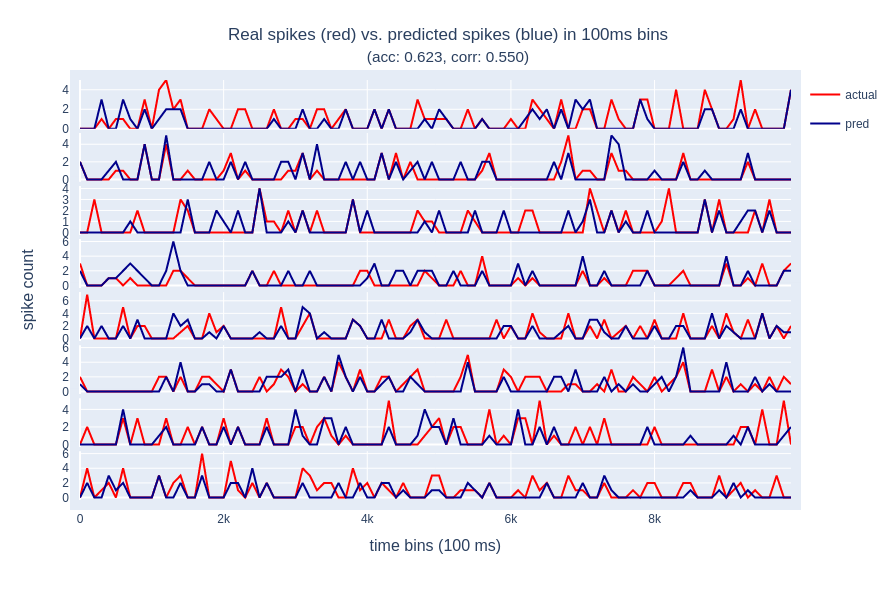

In [21]:
bin_ms = 100
histogram_bins = round(test_len_secs / (bin_ms / 1000))
histogram_bins = np.arange(0, test_len_steps + 1) * trainable.test_ds.stride
#print(f"bins: {histogram_bins}")
pred_hist = np.histogram(np.flatnonzero(pred[(0,0)]), bins=histogram_bins)
actual_hist = np.histogram(np.flatnonzero(actual[(0,0)]), bins=histogram_bins)
fig = do_stats(actual_hist[0], pred_hist[0], bin_ms)
fig.show()
fig.update_traces({"line_width": 3.5})
fig.write_image("../out/fig3.svg")
#fig = plotly.graph_objects.Figure()
#fig.add_trace(
#    plotly.graph_objects.Scatter(
#        x=pred_histogram[1],
#        y=pred_histogram[0],
#        name='pred')
#)
#fig.add_trace(
#    plotly.graph_objects.Scatter(
#        x=actual_histogram[1],
#        y=actual_histogram[0],
#        name='actual')
#)
#fig.show()

In [22]:
pearson_corr = scipy.stats.pearsonr(pred_hist[0], actual_hist[0])[0]
print(f"Pearson corr: {pearson_corr:.4f}")
#print(f'sklearn report:\n{sklearn.metrics.classification_report(actual_histogram[0], pred_histogram[0])}')

Pearson corr: 0.5496


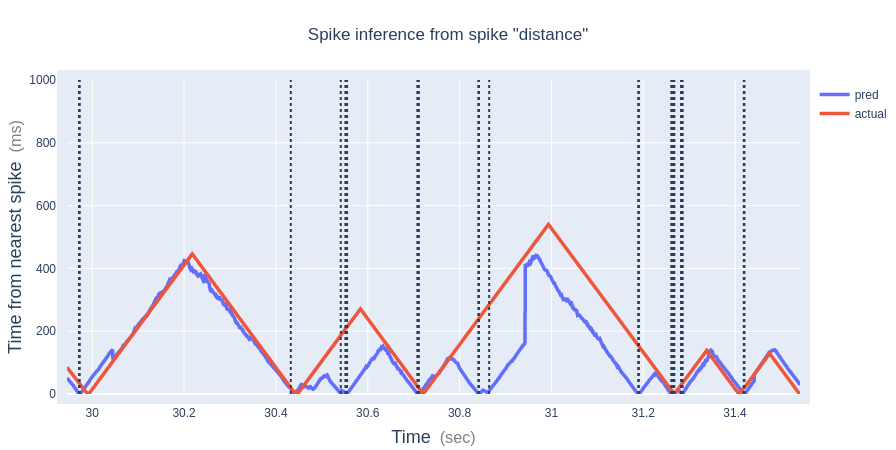

In [23]:
fig = plotly.graph_objects.Figure()
plot_range = np.arange(*np.array((300,316)) * trainable.test_ds.stride)
spike_idxs = np.flatnonzero(pred[(0,0)][plot_range] > 0) + plot_range[0]
show_pred = True
if show_pred:
    for indx in spike_idxs:
        fig.add_vline(
            x= indx / trainable.sample_rate, line_dash="dot")
fig.add_trace(
    plotly.graph_objects.Scatter(
        x=plot_range / trainable.sample_rate,
        y=pdist[(0,0)][plot_range],
        name="pred"
    )
)
fig.add_trace(
    plotly.graph_objects.Scatter(
        x=plot_range / trainable.sample_rate,
        y=adist[(0,0)][plot_range],
        name="actual"
    )
)
fig.update_layout({
    #"title": retinapy.vis.create_title("Time from nearest spike, for a single cell", "Predictions in 100ms chunks"),
    "title":retinapy.vis.create_title('Spike inference from spike "distance"', None),
    "yaxis_range": [0,1000],
    "margin":{"l":0, "r":0, "t":80, "b":10, "pad":10},
    "autosize":False,
    "width":800,
    "title_x":0.5,
    "title_pad":dict(l=1, r=1, b=20, t=20),
    "yaxis":{"title":{
        "text":retinapy.vis.create_axis_title('Time from nearest spike', 'ms'),
        "font_size": 18,
        },
    },
    "xaxis":{"title":{
        "text":retinapy.vis.create_axis_title('Time', 'sec'),
        "font_size": 18,
        },
    },
})
fig.update_traces({"line_width": 3.5})
fig.show()
fig.write_image("../out/fig2.svg")

torch.Size([1, 5, 3574])


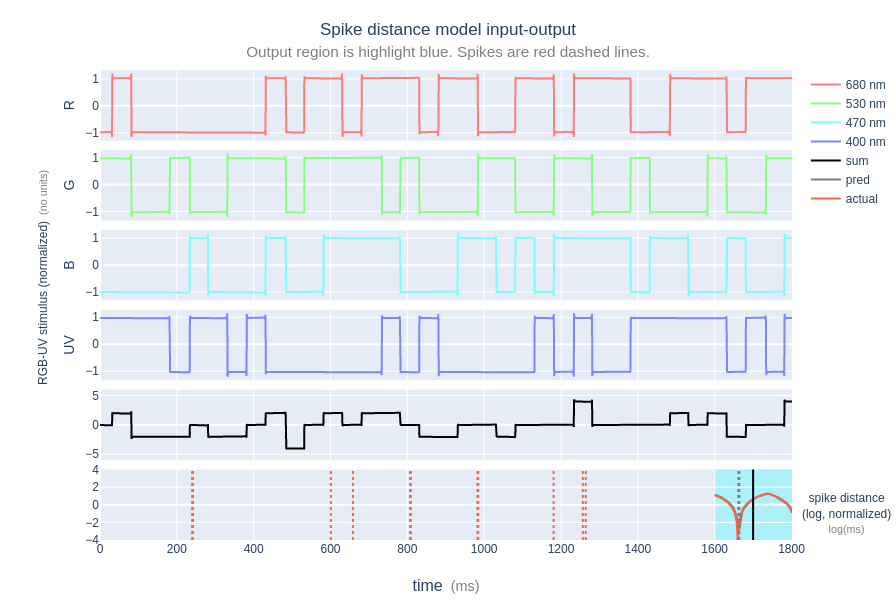

In [24]:
def debug_sample(idx):
    with torch.no_grad():
        #sample = trainable.test_ds[idx]
        sample = get_sample(trainable.test_ds, idx)
        model_out, _ = trainable.forward(sample)
        print(sample['snippet'].shape)
        input_spikes = sample['snippet'][0][:,-1]
        lhs_spike =  torch.clamp(
            torch.argmin((input_spikes > 0).int()) - len(input_spikes),
            -trainable.max_bin_dist)
        p_spikes = predict(trainable, model_out, lhs_spike)
        fig = retinapy.vis.distfield_model_in_out(
            stimulus=sample['snippet'][0][0:-1].numpy(),
            in_spikes=sample['snippet'][0][-1].numpy(),
            target_dist=trainable.distfield_to_nn_output(sample['dist'][0]).numpy(),
            model_out=model_out[0].cpu().numpy(),
            out_spikes=p_spikes.cpu().numpy(),
            bin_duration_ms=trainable.sample_period_ms)
        fig.add_vline(
            x=1700, line_color="black", line_dash="solid", row=6, col=1
        )
        return fig
for i in range(0, 1):
    fig = debug_sample(41 + i)
    fig.show()
    fig.update_traces({"line_width": 3.5})
    #fig.update_layout({"yaxis": {"title": {"font_size": 50}}})
    fig.write_image("../out/fig1.svg")